# Regression of Used Car Prices

The goal of this competition is to predict the price of used cars based on various features.

In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
from fastkaggle import setup_comp
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score,train_test_split

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,Pool, metrics, cv





import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler
import warnings


matplotlib.rc('image', cmap='Greys')
import scipy.stats as stats


#from openfe import OpenFE, transform
from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc
import wandb

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

In [2]:
!ls playground-series-s4e9

sample_submission.csv  test.csv  train.csv  used_cars.csv


In [3]:
path = Path('playground-series-s4e9/')
path

Path('playground-series-s4e9')

In [4]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
used_cars = pd.read_csv(path/'used_cars.csv')

In [5]:
comp = 'playground-series-s4e9'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('playground-series-s4e9/')
else:
    import zipfile,kaggle
    path = Path('playground-series-s4e9')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

# Exploratory Data Analysis

In [6]:
train_df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900


## Dataset description from the original dataset

Brand & Model: Identify the brand or company name along with the specific model of each vehicle.


Model Year: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements



Mileage: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirement
s
.
Fuel Type: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybr

id.
Engine Type: Understand the engine specifications, shedding light on performance and efficie

ncy.
Transmission: Determine the transmission type, whether automatic, manual, or another var

iant.
Exterior & Interior Colors: Explore the aesthetic aspects of the vehicles, including exterior and interior color op

tions.
Accident History: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-

making.
Clean Title: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal

 status.
Price: Access the listed prices for each vehicle, aiding in price comparison and budgeting.

In [6]:
train_df.shape,test_df.shape,used_cars.shape

((188533, 12), (125690, 11), (4009, 12))

In [7]:
train_df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

#### Check for missing values

In [8]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

clean_title     21419
fuel_type        5083
accident         2452
brand               0
model               0
model_year          0
milage              0
engine              0
transmission        0
ext_col             0
int_col             0
price               0
dtype: int64


In [9]:
#Missing values returned as percentages.
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

clean_title     11.360876
fuel_type        2.696080
accident         1.300568
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
price            0.000000
dtype: float64


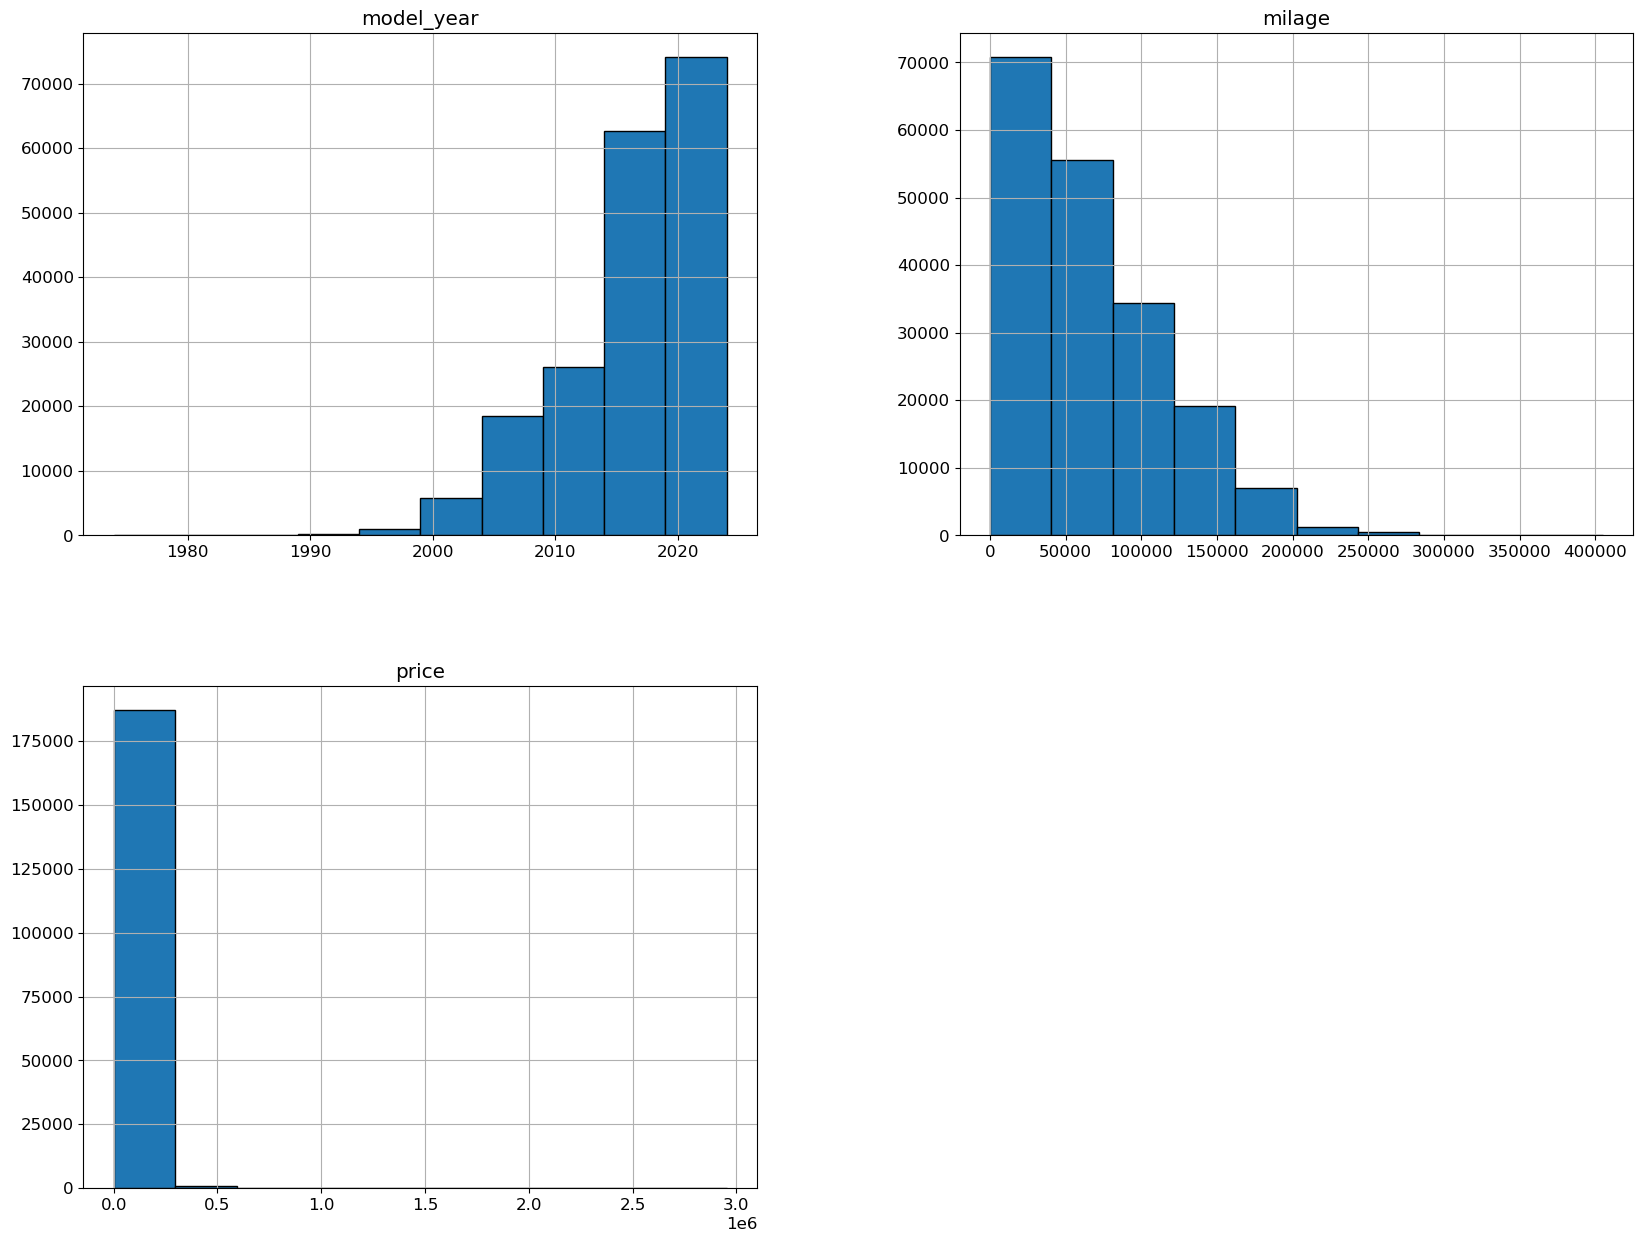

In [10]:
train_df.hist(figsize=(20,15),edgecolor='black');

## Data Inspection

#### For categorical variables

In [12]:
train_df.describe(include=[object]).T

,count,unique,top,freq
brand,188533,57,Ford,23088
model,188533,1897,F-150 XLT,2945
fuel_type,183450,7,Gasoline,165940
engine,188533,1117,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,3462
transmission,188533,52,A/T,49904
ext_col,188533,319,Black,48658
int_col,188533,156,Black,107674
accident,186081,2,None reported,144514
clean_title,167114,1,Yes,167114


#### For continous variables

In [13]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


#### Check for encoding

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


## Data Visualization

Here we are going to take a look at our data and get to know our variables and their relationships between them.

### Univariate Analysis

Here, we shall inspect our features individually to try to understand the factors being used to predict the price. I shall start with my continuous/quantitative variables.
Based on the feature encoding and types, we know we have three variables inclusive of the target that can be treated as continuous variables, namely price, model_year and mileage. 

I shall go ahead and visualize them with some box plots and bar plots which enable us to visualize the spread, mean and range of our values

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


From the missing value check before, we know that none of these have any missing values.

#### Mileage encoded as Milage

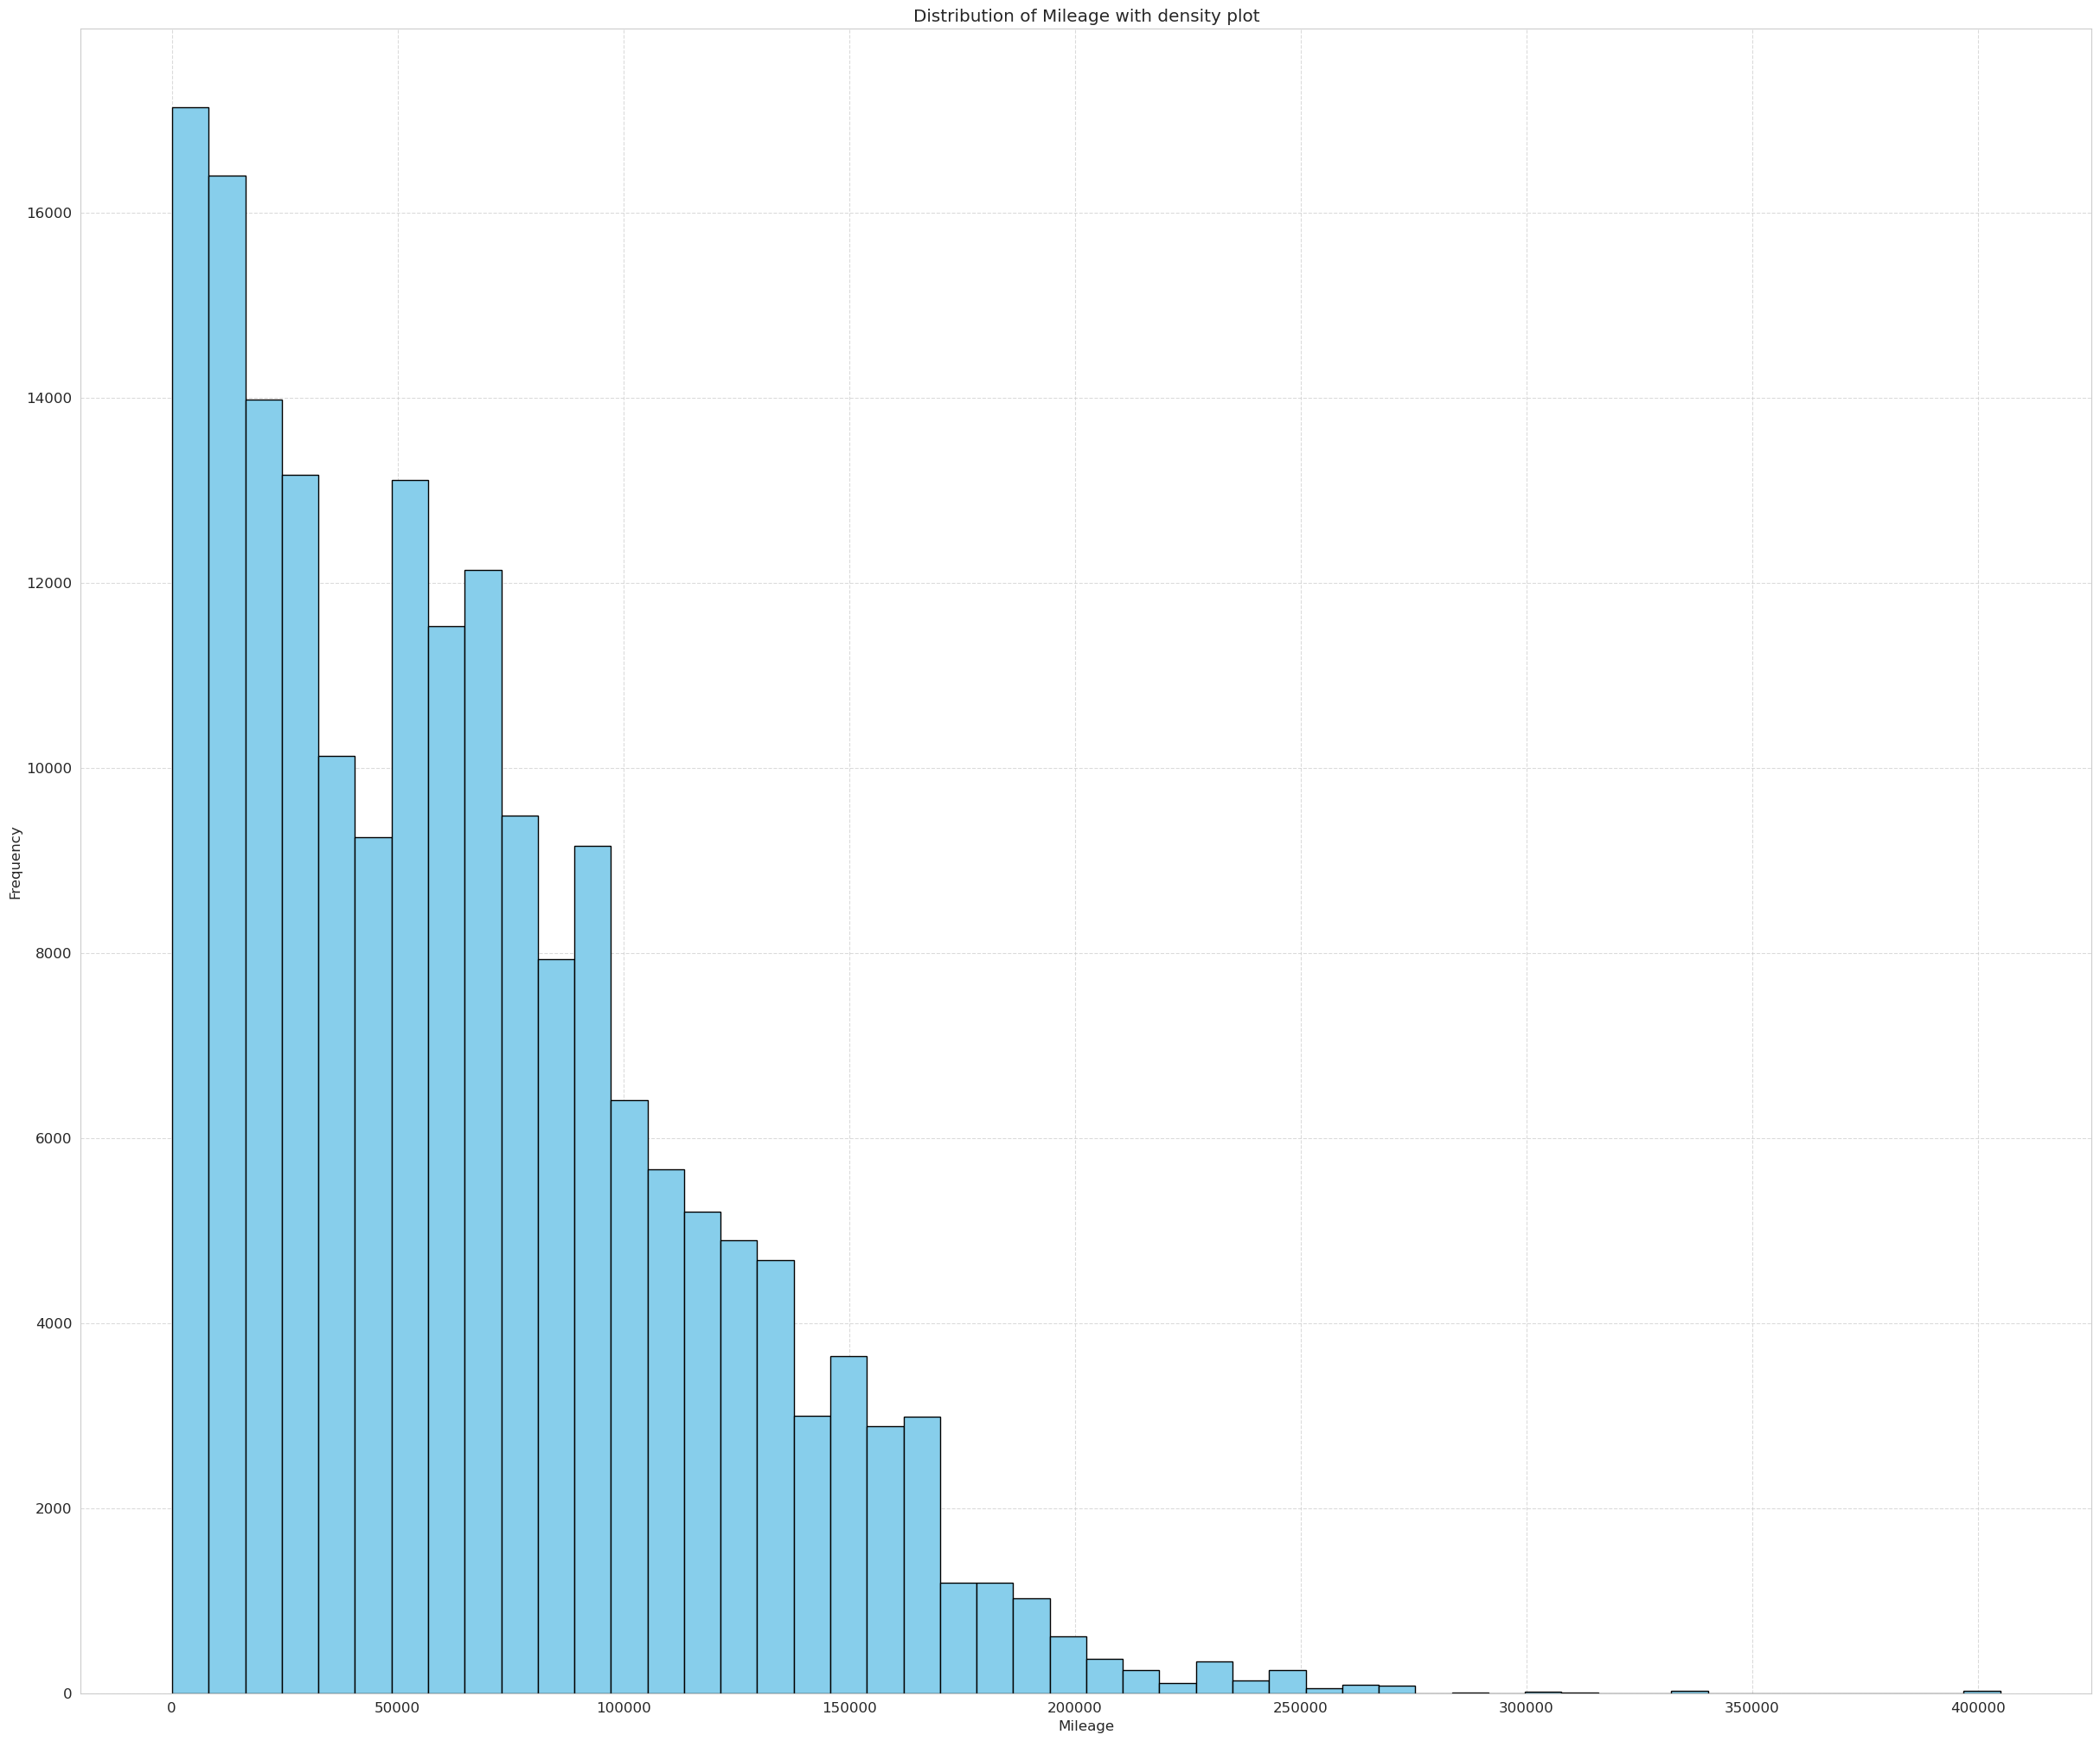

In [51]:
#train_df['milage'].hist(figsize=(20,15),edgecolor='black');
train_df['milage'].hist(figsize=(10,6), edgecolor='black', color='skyblue', bins=30)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.title('Distribution of Mileage')
plt.show()

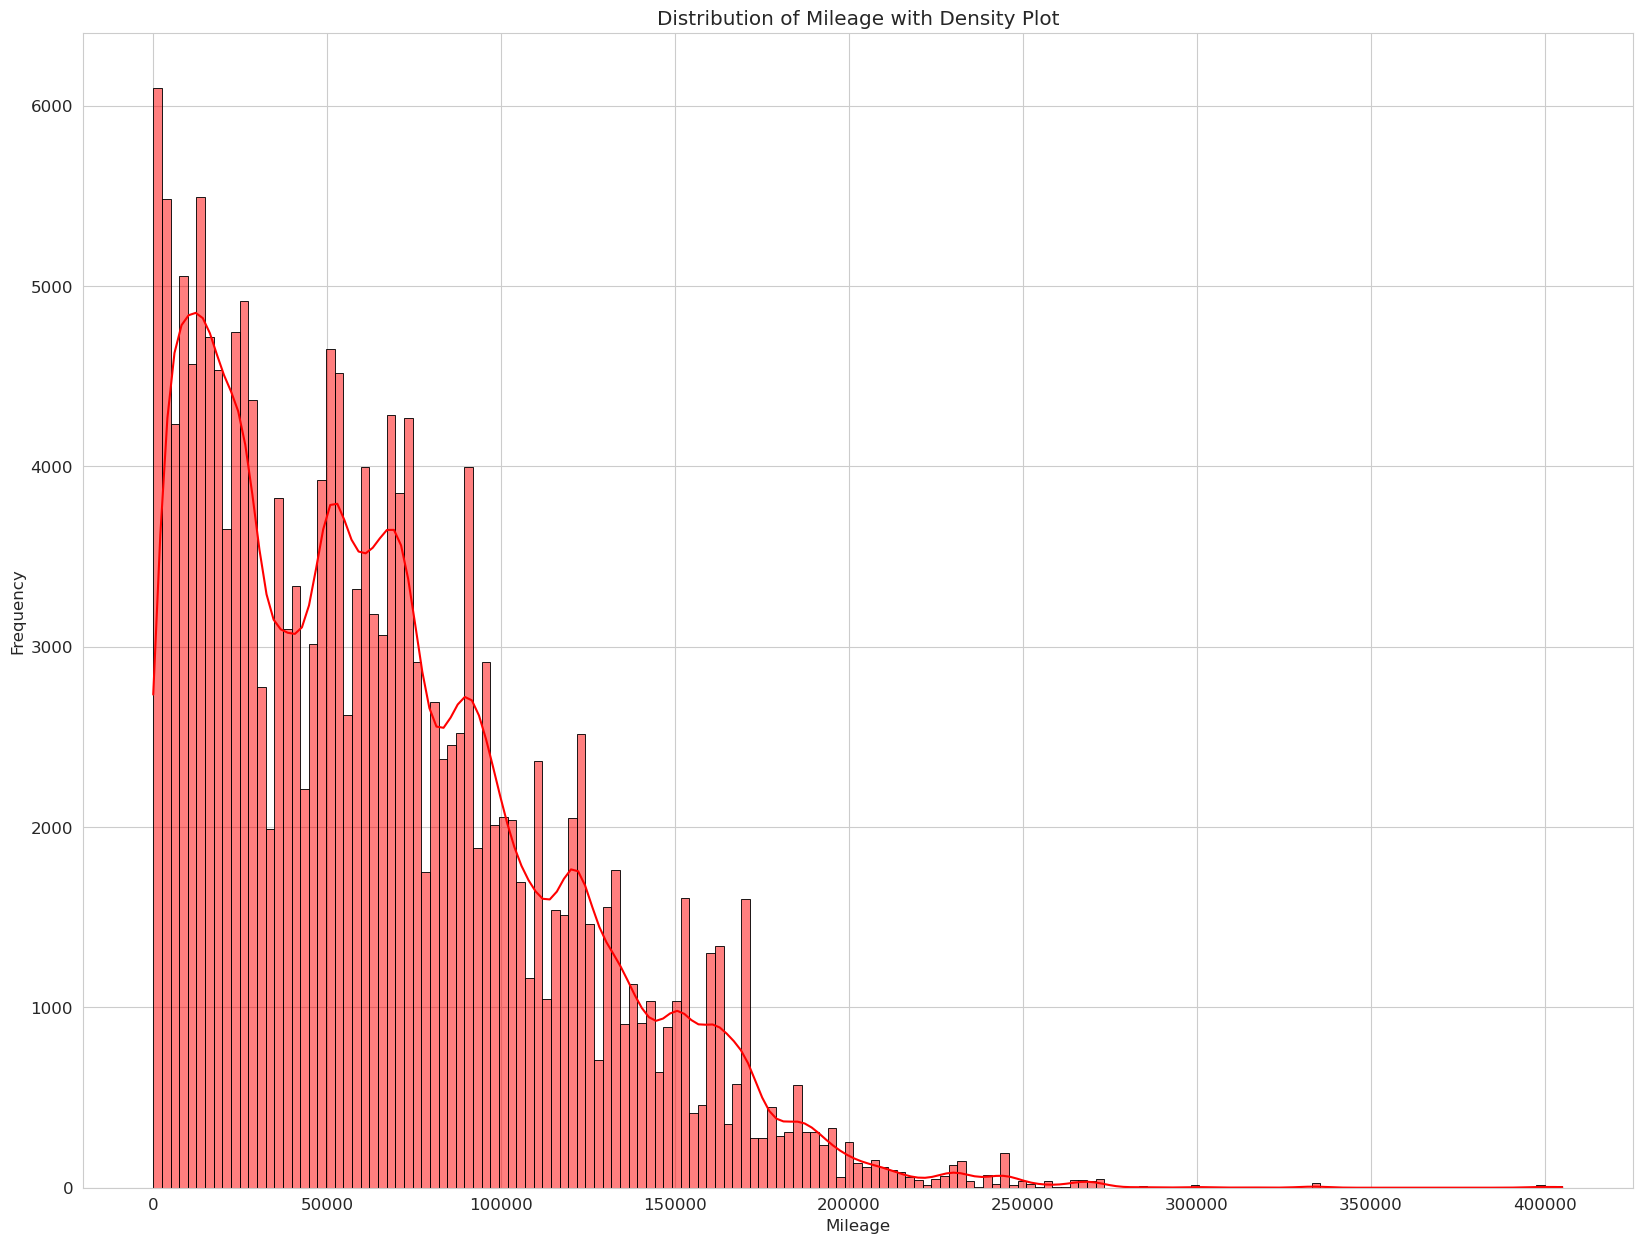

In [11]:
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))

sns.histplot(data=train_df, x='milage', kde=True, color='red', edgecolor='black', ax=ax)

plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.title('Distribution of Mileage with Density Plot')
plt.show()

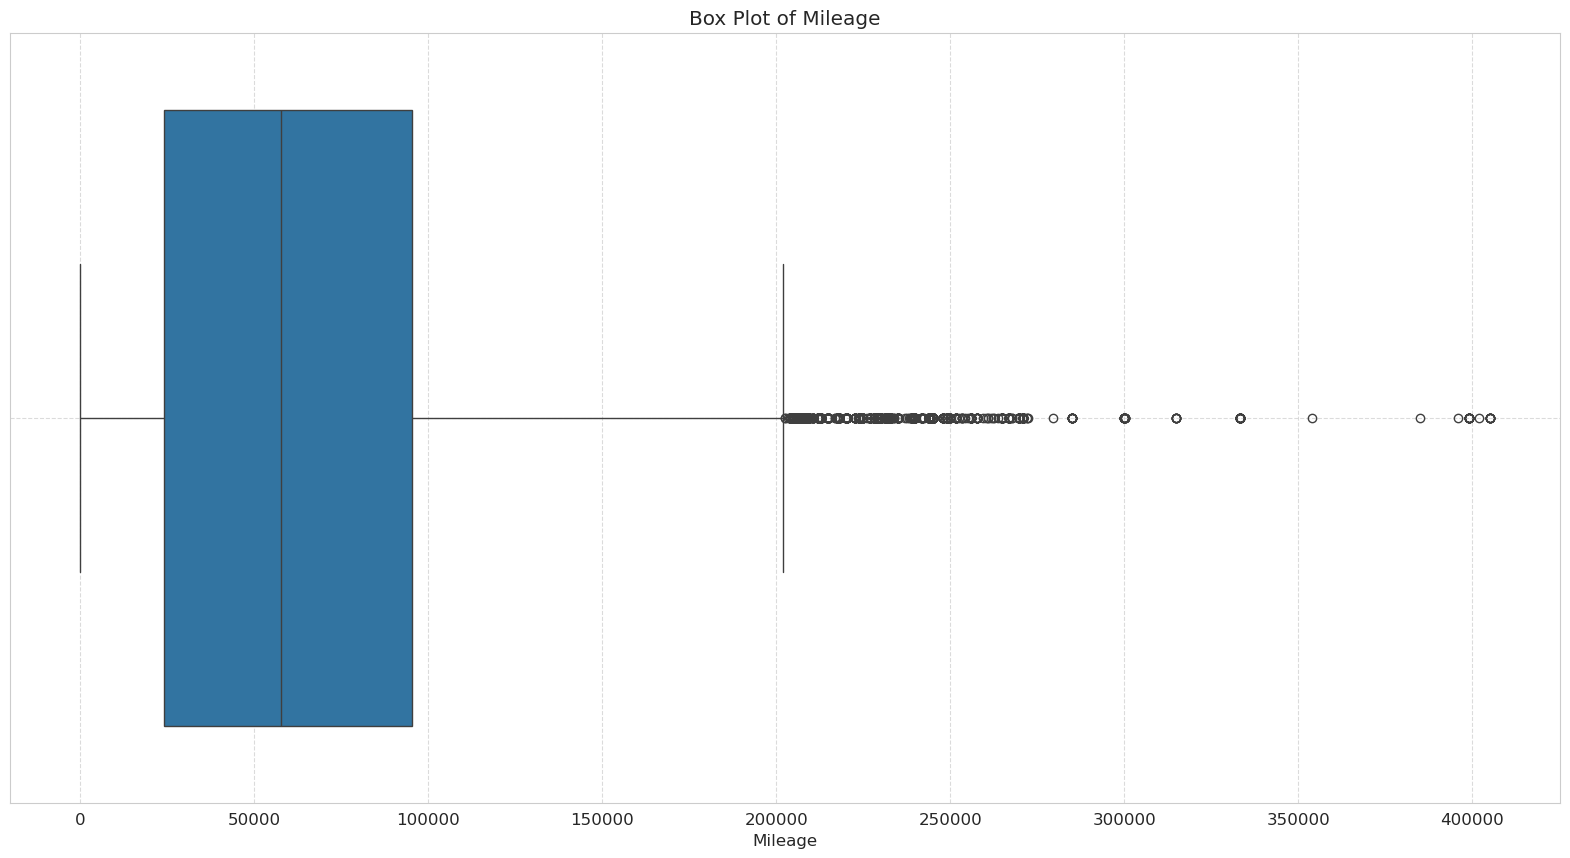

In [22]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='milage', data=train_df)

plt.title('Box Plot of Mileage')
plt.xlabel('Mileage')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

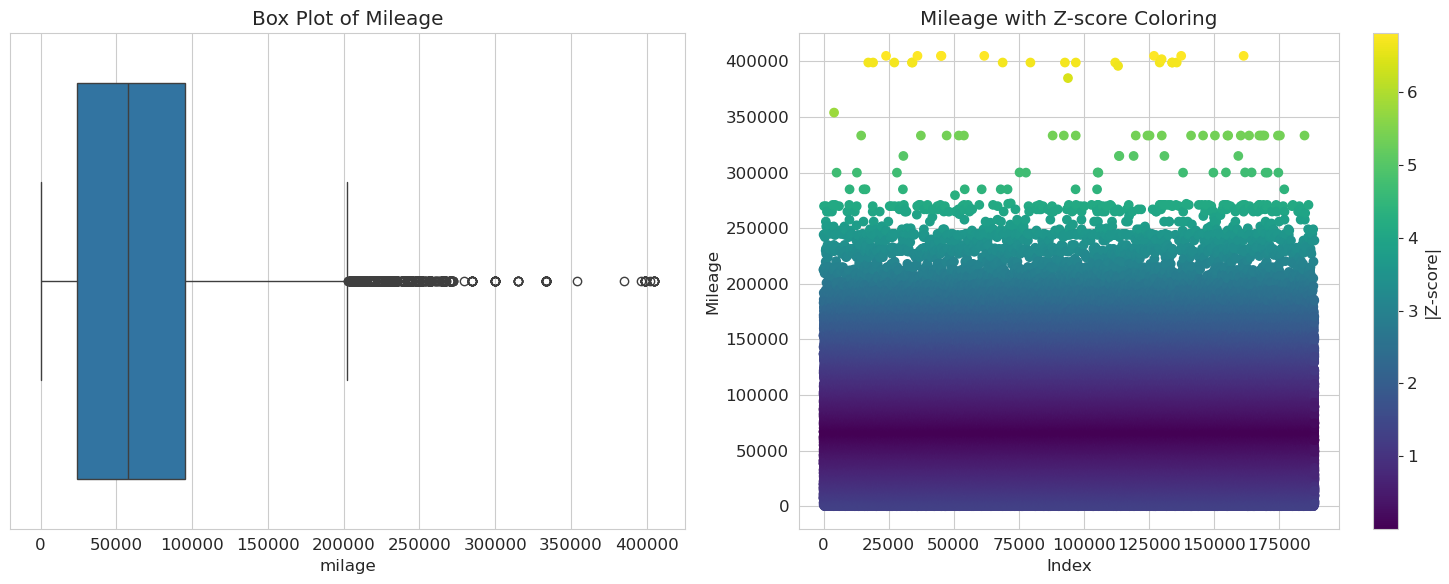

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
sns.boxplot(x=train_df['milage'], ax=ax1)
ax1.set_title('Box Plot of Mileage')

# Scatter plot with z-score
z_scores = stats.zscore(train_df['milage'])
ax2.scatter(range(len(train_df['milage'])), train_df['milage'], c=abs(z_scores), cmap='viridis')
ax2.set_title('Mileage with Z-score Coloring')
ax2.set_xlabel('Index')
ax2.set_ylabel('Mileage')

plt.colorbar(ax2.collections[0], ax=ax2, label='|Z-score|')
plt.tight_layout()
plt.show()

#### model_year

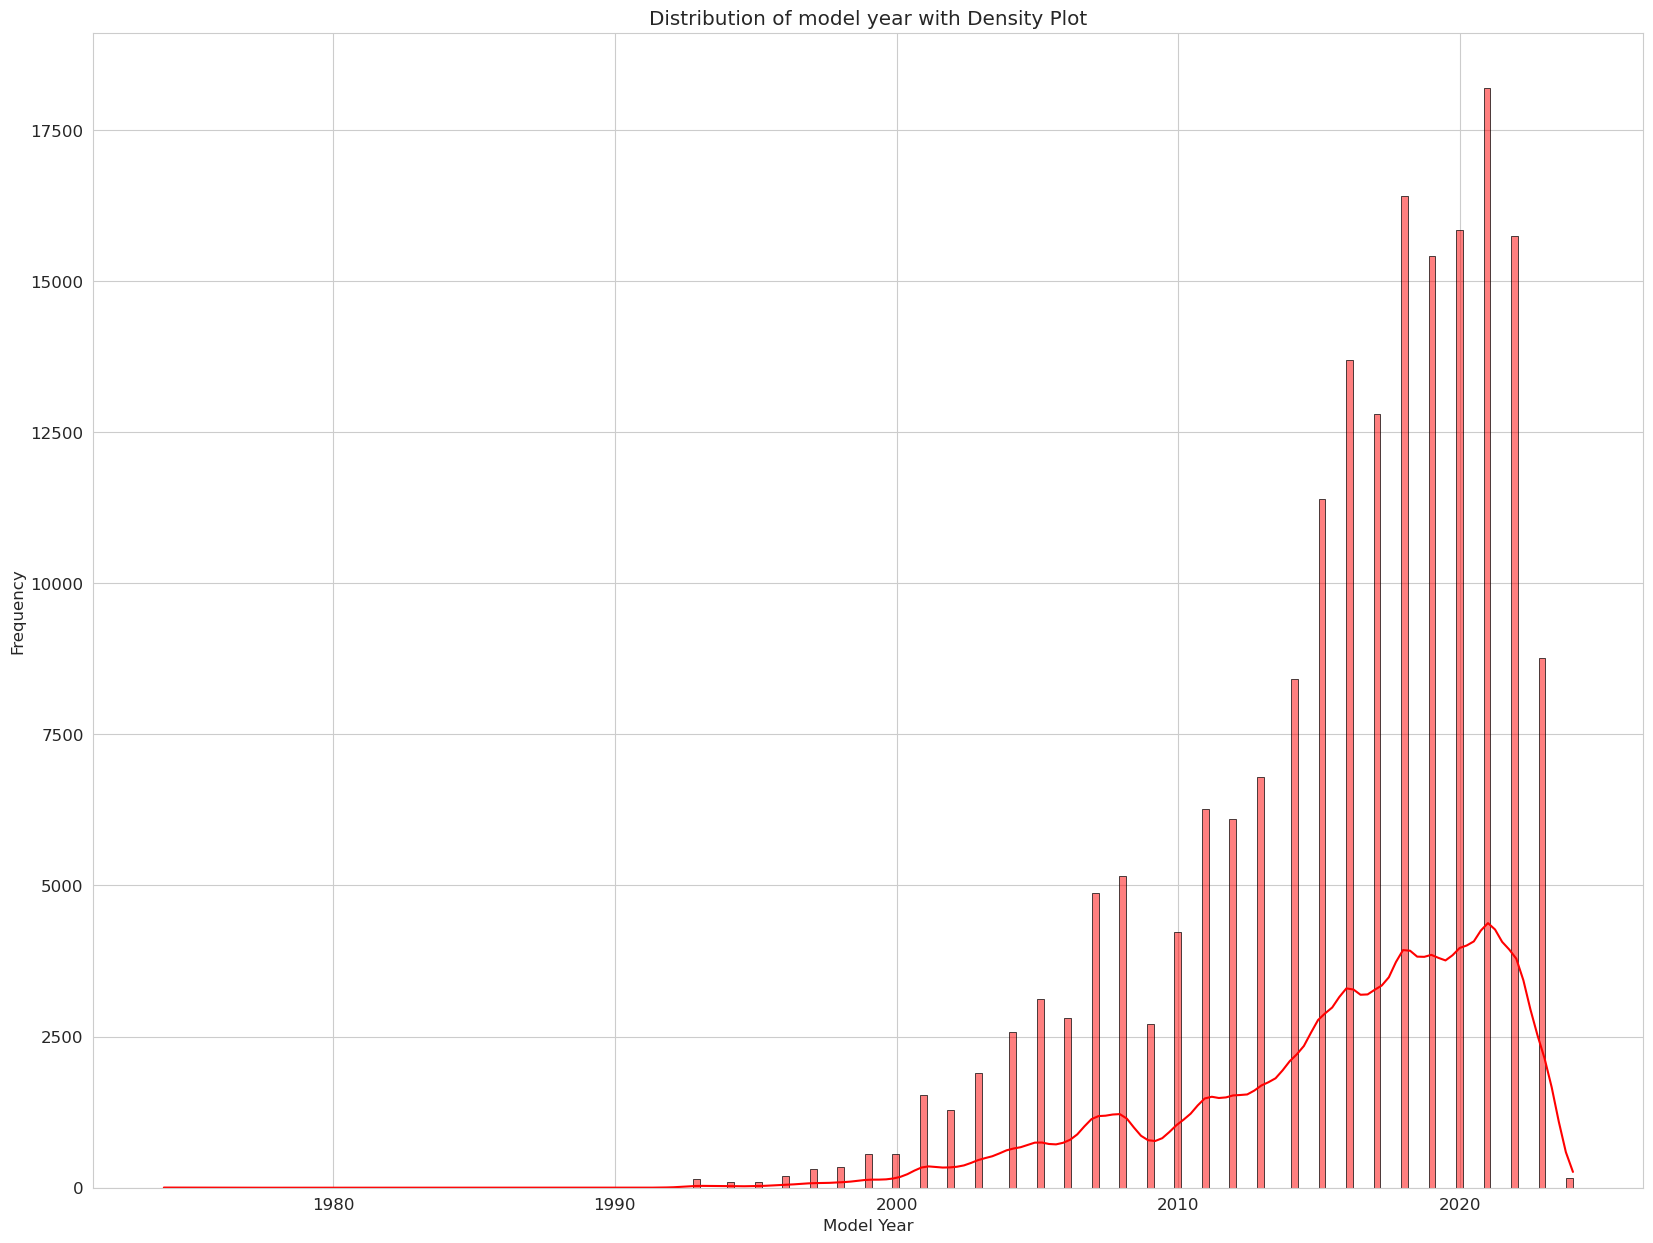

In [24]:
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))

sns.histplot(data=train_df, x='model_year', kde=True, color='red', edgecolor='black', ax=ax)

plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.title('Distribution of model year with Density Plot')
plt.show()

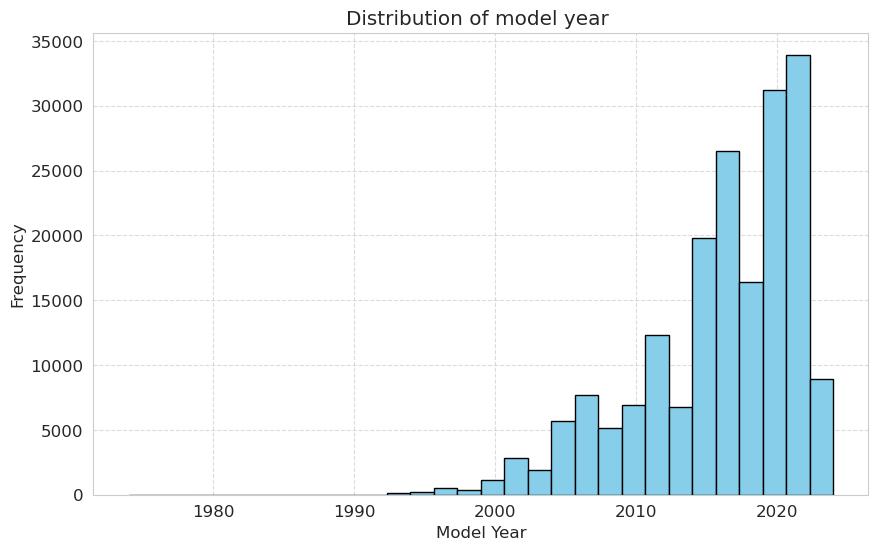

In [26]:
#train_df['milage'].hist(figsize=(20,15),edgecolor='black');
train_df['model_year'].hist(figsize=(10,6), edgecolor='black', color='skyblue', bins=30)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.title('Distribution of model year ')
plt.show()

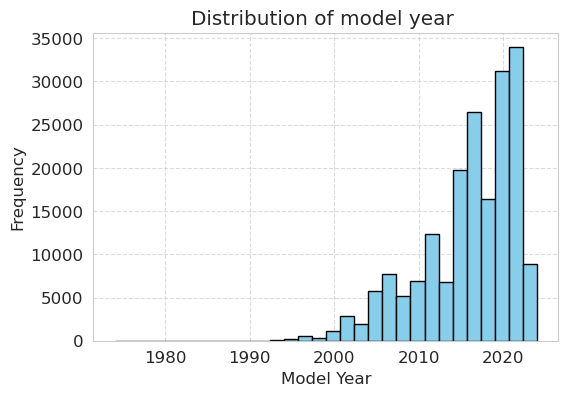

In [33]:
#train_df['milage'].hist(figsize=(20,15),edgecolor='black');
train_df['model_year'].hist(figsize=(6,4), edgecolor='black', color='skyblue', bins=30)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.title('Distribution of model year ')
plt.show()

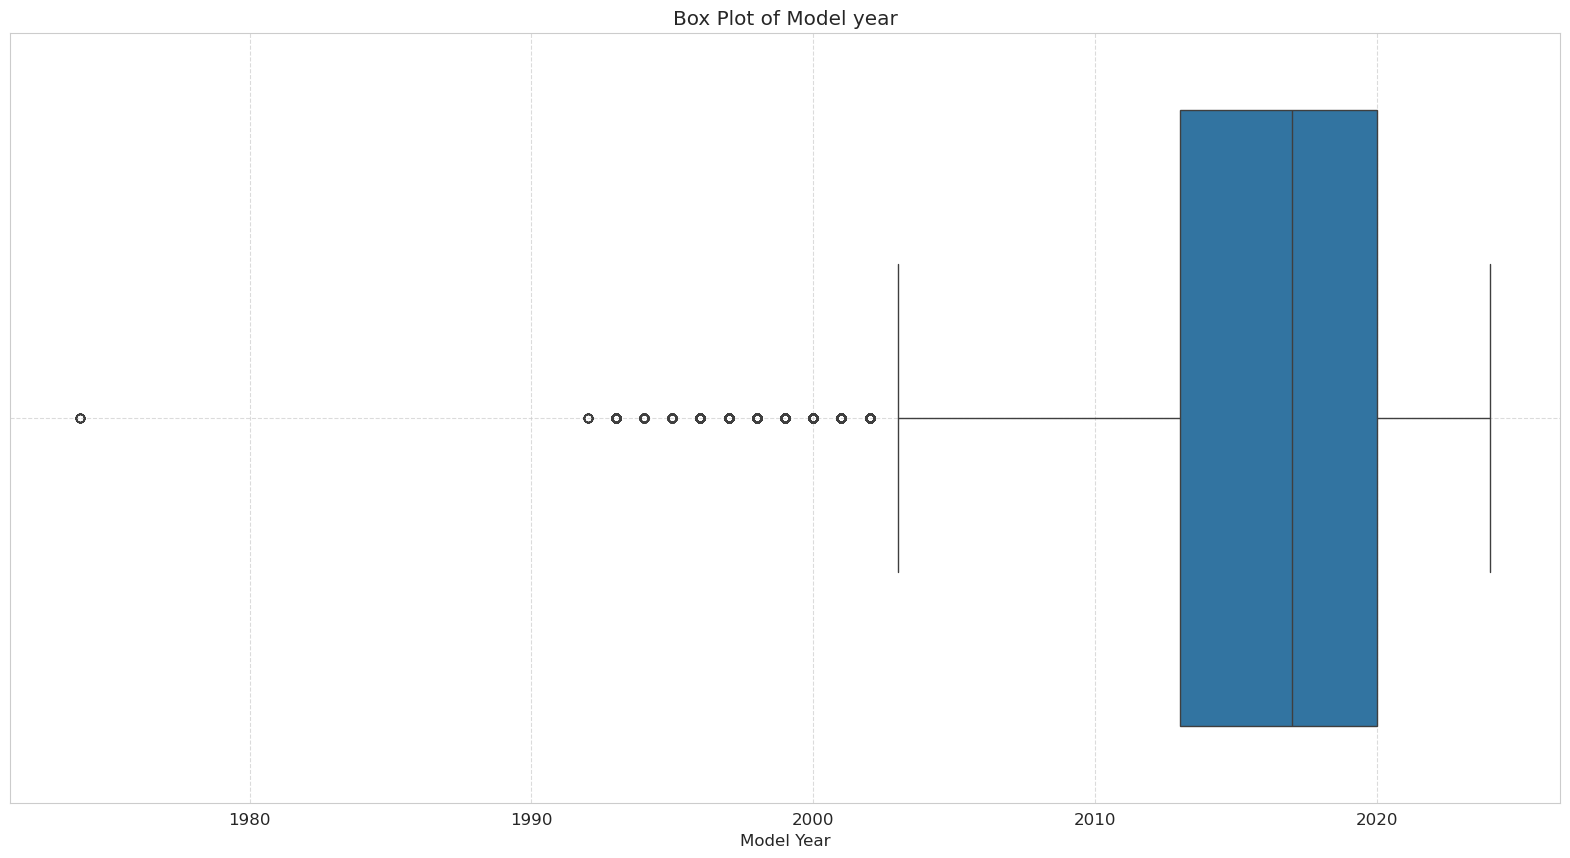

In [27]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='model_year', data=train_df)

plt.title('Box Plot of Model year')
plt.xlabel('Model Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Target variable exploration

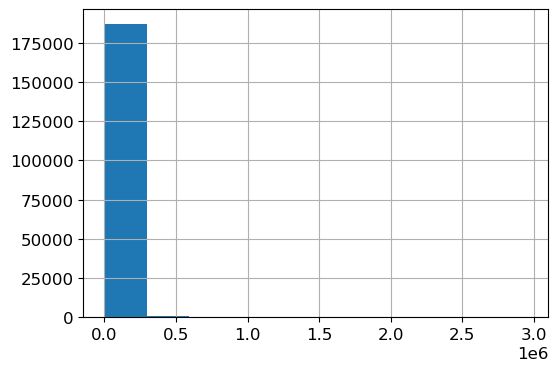

In [15]:
train_df['price'].hist(figsize=(6,4));

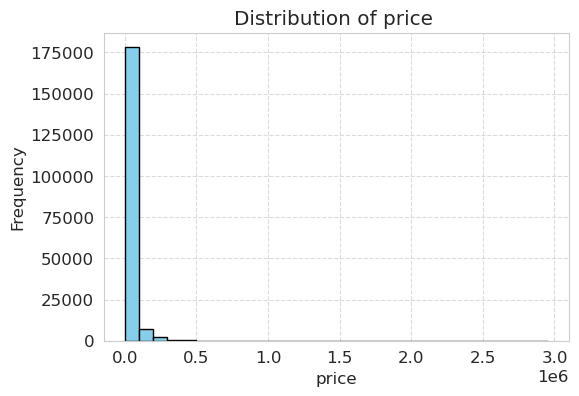

In [35]:
#train_df['milage'].hist(figsize=(20,15),edgecolor='black');
train_df['price'].hist(figsize=(6,4), edgecolor='black', color='skyblue', bins=30)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('price')
plt.ylabel('Frequency')
plt.title('Distribution of price ')
plt.show()

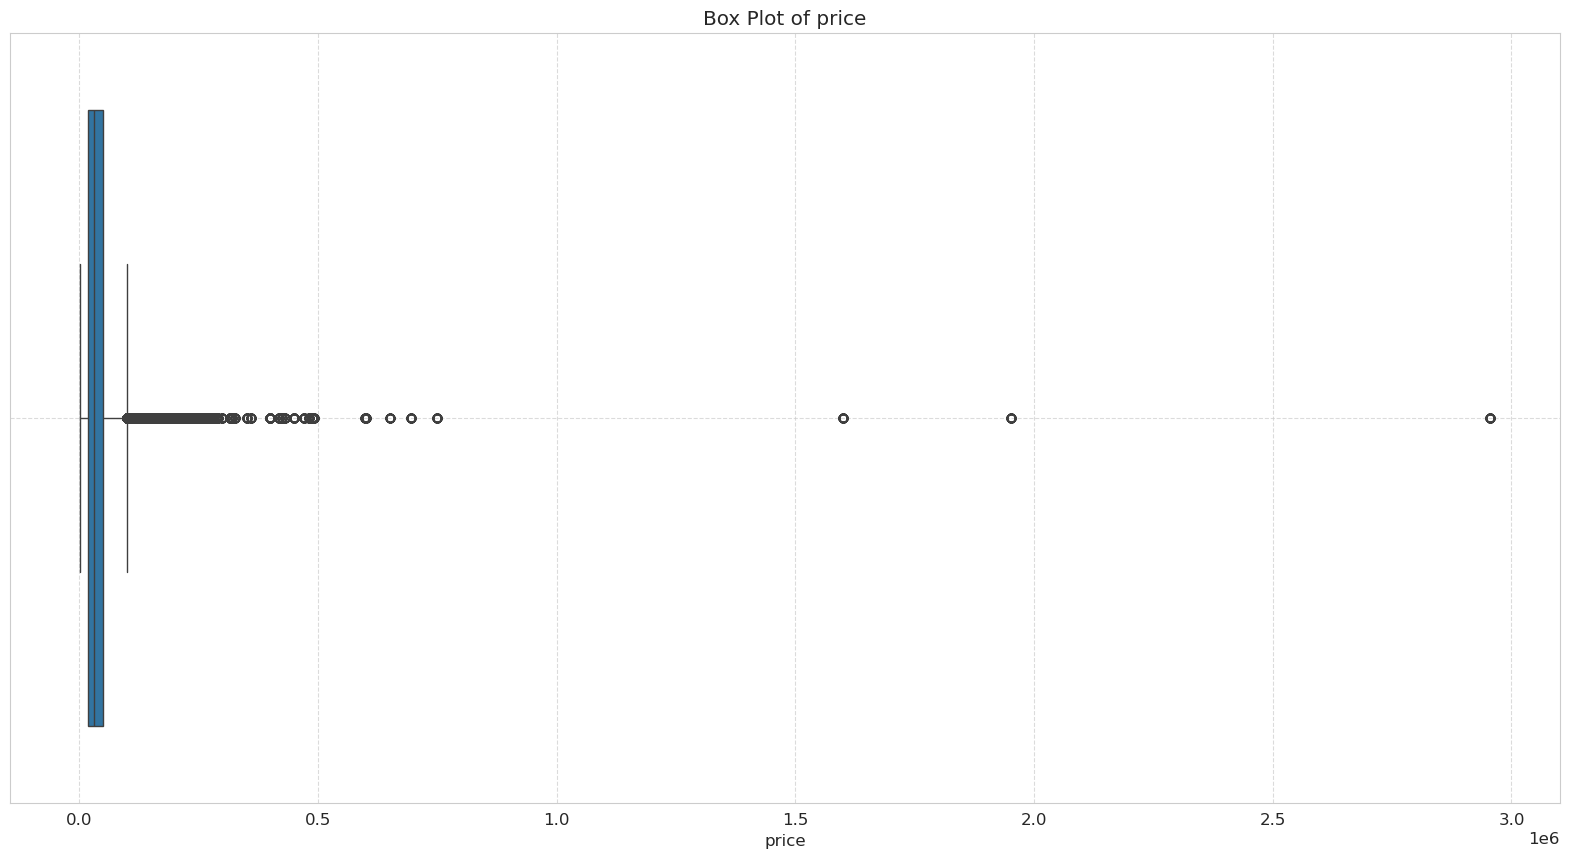

In [32]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='price', data=train_df)

plt.title('Box Plot of price')
plt.xlabel('price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Observations

We notice that milage has a lot of outliers which can be seen by the points outside the whiskers.

# Data Preprocessing

#### Split into categorical and continous

In [37]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='price')
len(cat_names),len(cont_names)

(9, 2)

#### Split into training and validation set

The RandomSplitter below separates the training set into a training and validation set based off the value of the argument valid_pct.

In [38]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

#### TabularPandas

Below we define a TabularPandas object.

Here we declare the continous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting and the type of problem we are optimizing for such as binary classification in this case.

In [39]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='price',
                   y_block=RegressionBlock(),
                   splits=splits)

#### DataLoaders

We define a dataloaders which prepares our data for input into our neural network.Here we can define our batch size.

In [40]:
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

#### Prepare dataset for GBM'S and decision trees

In [41]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [42]:
X_train

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,model_year,milage
id,,,,,,,,,,,
157595,39,945,3,471,13,264,15,2,1,-1.562559,1.130149
186426,54,1288,3,135,9,305,11,2,1,-2.269553,0.980167
40380,10,402,3,914,21,39,15,2,1,0.028176,-0.515796
126004,40,733,3,395,11,129,72,2,1,-0.678817,0.889279
164417,5,49,3,353,50,129,15,1,1,0.204925,-0.094273
...,...,...,...,...,...,...,...,...,...,...,...
7093,4,172,3,273,39,264,72,2,1,-0.325321,-0.274926
54160,16,244,3,546,37,95,80,2,0,0.911918,-0.707387
126302,40,60,3,473,13,264,15,2,1,-2.799798,1.326860


# Modelling

In [43]:
lgbm_params = {
    'learning_rate': 0.02956613668999794, 
    'n_estimators': 483,
    'reg_alpha': 0.0011093389440775324,
    'reg_lambda': 0.15936937364526085,
    'colsample_bytree': 0.4533510196891779,
    'subsample': 0.9272807625455266,
    'max_depth': 82,
    'min_child_weight': 4,
    'gamma': 0.0033558210410357075,
    'max_leaves': 873,  
}

cat_params = {
    #'eval_metric': 'AUC',
    'learning_rate': 0.005,
    'iterations': 10000,
    'depth': 9,
    'random_strength': 0,
    'l2_leaf_reg': 0.5,
    'max_leaves': 512,
    'fold_permutation_block': 64,
    #'task_type': 'GPU',
    #'devices': '0:1',
    'random_seed': 42,
    'verbose': False,
    'allow_writing_files': False
}

xgb_optuna_params = {
    'learning_rate': 0.0071851097672265855, 
    'n_estimators': 1851,
    'reg_alpha': 0.0011093389440775324,
    'reg_lambda': 0.15936937364526085,
    'colsample_bytree': 0.4533510196891779,
    'subsample': 0.9272807625455266,
    'max_depth': 20,
    'min_child_weight': 4,
    'gamma': 0.0033558210410357075,
    'max_leaves': 873,
    #'device': 'gpu'
}

# Neural Network

In [48]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(valley=0.2089296132326126)

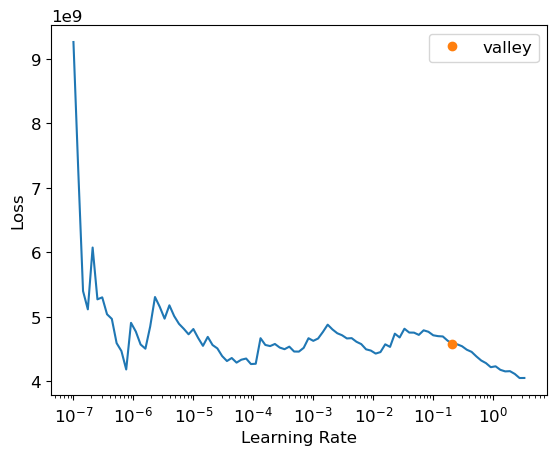

In [51]:
learn.lr_find()

In [ ]:
%%time
learn.fit_one_cycle(10,0.012)

In [ ]:
learn.save('nn_model_with_orig_ds')

# Random Forests

In [43]:
%%time

rf = RandomForestRegressor(500, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = root_mean_squared_error(y_test, rf_preds_x)
print(f"Final Random forests RMSE on test set: {rf_score}")

Final Random forests RMSE on test set: 74279.53255416482
CPU times: user 5min 34s, sys: 2.06 s, total: 5min 36s
Wall time: 5min 34s


# XGBoost

In [38]:
xgb_optuna_params = {
    'learning_rate': 0.0071851097672265855, 
    'n_estimators': 1851,
}

In [39]:
%%time
xgb_model = xgb.XGBRegressor(**xgb_optuna_params)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = root_mean_squared_error(y_test,xgb_preds_x)
print(f"Final XGB RMSE on test set: {xgb_score}")

Final XGB RMSE on test set: 73282.31960099326
CPU times: user 30.8 s, sys: 189 ms, total: 31 s
Wall time: 7.76 s


In [38]:
%%time
xgb_model = xgb.XGBRegressor(**xgb_optuna_params)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = root_mean_squared_error(y_test,xgb_preds_x)
print(f"Final XGB RMSE on test set: {xgb_score}")

Final XGB RMSE on test set: 73878.69060156752
CPU times: user 2min 27s, sys: 1.68 s, total: 2min 29s
Wall time: 37.4 s


In [37]:
K_FOLDS = 10  # Number of folds for cross-validation
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    xgb_model_fold = xgb.XGBRegressor(**xgb_optuna_params)
    xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = xgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    xgb_score = root_mean_squared_error(y_fold_val, y_pred_fold)
    fold_scores.append(xgb_score)
    
    print(f"Fold {fold} RMSE: {xgb_score}")

# Calculate and print the mean score across all folds
xgb_mean_score = np.mean(fold_scores)
print(f"Mean RMSE: {xgb_mean_score}")

Fold 1 RMSE: 70818.16474726211
Fold 2 RMSE: 61016.48202934407
Fold 3 RMSE: 77038.20724717848
Fold 4 RMSE: 56212.54882826404
Fold 5 RMSE: 80229.71341279928
Fold 6 RMSE: 80932.4965942731
Fold 7 RMSE: 77372.89109182911
Fold 8 RMSE: 78719.47512733248
Fold 9 RMSE: 90994.79832986933
Fold 10 RMSE: 66701.21957010159
Mean RMSE: 74003.59969782535


In [39]:
with open('xgb_model_fold_exp1.pkl', 'wb') as file:
    pickle.dump(xgb_model_fold, file)

# To load the model later
#with open('voting_classifier_model_with_og_ds.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

# Save the model
dump(xgb_model_fold, 'xgb_model_fold_exp1.joblib')

# To load the model later
#loaded_model = load('voting_classifier_model_with_og_ds..joblib')

['xgb_model_fold_exp1.joblib']

# LGBM

In [44]:
%%time
lgbm_model = lgb.LGBMRegressor(**lgbm_params)
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

#validation set preds
lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = root_mean_squared_error(y_test,lgbm_preds_x)
print(f"Final LGBM RMSE on test set: {lgbm_score}")

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 150827, number of used features: 11
[LightGBM] [Info] Start training from score 43981.320546
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num

In [45]:
!rm submission.csv
submit = pd.read_csv(path/'sample_submission.csv')
submit['price'] = lgbm_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,price
0,188533,17630.559
1,188534,82307.280
2,188535,53860.934
3,188536,21947.291
4,188537,30219.926
...,...,...
125685,314218,29266.690
125686,314219,48020.832
125687,314220,21558.406
125688,314221,16819.473


In [46]:
!kaggle competitions submit -c playground-series-s4e9 -f submission.csv -m "[LGBM] Silver Rubanza, Regular LGBM without CV - Local PC  "

100%|███████████████████████████████████████| 1.99M/1.99M [00:02<00:00, 744kB/s]
Successfully submitted to Regression of Used Car Prices

In [47]:
%%time
K_FOLDS = 10  # Number of folds for cross-validation
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgbm_fold_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    lgbm_model_fold = lgb.LGBMRegressor(**lgbm_params)
    lgbm_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = lgbm_model_fold.predict(X_fold_val)
    #y_pred_fold_tt = lgbm_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Root Mean Squared Error for the current fold
    lgbm_cv_score = root_mean_squared_error(y_fold_val, y_pred_fold)
    lgbm_fold_scores.append(lgbm_cv_score)
    
    print(f"Fold {fold} RMSE: {lgbm_cv_score}")

# Calculate and print the mean score across all folds
lgbm_mean_score = np.mean(lgbm_fold_scores)
print(f"Mean RMSE: {lgbm_mean_score}")

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 135744, number of used features: 11
[LightGBM] [Info] Start training from score 44000.146997
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
Fold 1 RMSE: 68885.5252384483
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Un

In [48]:
lgbm_mean_score = np.mean(lgbm_fold_scores)
print(f"Mean RMSE: {lgbm_mean_score}")

Mean RMSE: 72213.4257865588


In [49]:
y_pred_fold_tt = lgbm_model_fold.predict(test_dl.xs)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31


In [50]:
y_pred_fold_scoring = lgbm_model_fold.predict(X_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31


In [76]:
y_pred_fold_scoring.shape,lgbm_preds_x.shape

((37706,), torch.Size([37706]))

In [51]:
lgbm_cv_score = root_mean_squared_error(y_test,y_pred_fold_scoring)
print(f"Final LGBM RMSE on test set: {lgbm_cv_score}")

Final LGBM RMSE on test set: 72758.61913116358


In [35]:
with open('lgbm_model_fold.pkl', 'wb') as file:
    pickle.dump(lgbm_model_fold, file)

# To load the model later
#with open('voting_classifier_model_with_og_ds.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

# Save the model
dump(lgbm_model_fold, 'lgbm_model_fold.joblib')

# To load the model later
#loaded_model = load('voting_classifier_model_with_og_ds..joblib')

['lgbm_model_fold.joblib']

In [36]:
!ls

AutogluonModels		     playground-series-s4e9
LICENSE			     playground-series-s4e9.zip
README.md		     playground-series-s4e9.zip:Zone.Identifier
kaggle.json		     submission.csv
kaggle.json:Zone.Identifier  used_cars.csv:Zone.Identifier
kernel-metadata.json	     used_cars_voting.ipynb
lgbm_model_fold.joblib	     voting_regressor_model_with_og_ds.joblib
lgbm_model_fold.pkl	     voting_regressor_model_with_og_ds.pkl
models


In [24]:
y_pred_fold_tt.shape,train_df.shape,test_df.shape

((125690,), (188533, 12), (125690, 11))

In [21]:
sub_df

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016
...,...,...
125685,314218,43878.016
125686,314219,43878.016
125687,314220,43878.016
125688,314221,43878.016


In [52]:
!rm submission.csv
submit = pd.read_csv(path/'sample_submission.csv')
submit['price'] = y_pred_fold_tt
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,price
0,188533,17354.454286
1,188534,83653.744234
2,188535,54777.027285
3,188536,22315.275892
4,188537,29978.768786
...,...,...
125685,314218,29374.924292
125686,314219,46707.212303
125687,314220,21412.618335
125688,314221,16625.944255


In [58]:
!kaggle competitions submit -c playground-series-s4e9 -f submission.csv -m "[LGBM] Silver Rubanza, LGBM 10 regular Kfold- Local PC  "

100%|██████████████████████████████████████| 3.04M/3.04M [00:03<00:00, 1.02MB/s]
Successfully submitted to Regression of Used Car Prices

# CatBoost

In [59]:
%%time
cat_model = CatBoostRegressor(**cat_params)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = root_mean_squared_error(y_test,cat_preds_x)
print(f"Final CATBoost RMSE on test set: {cat_score}")

Final CATBoost RMSE on test set: 72738.84873944252
CPU times: user 20min 18s, sys: 3min 37s, total: 23min 55s
Wall time: 4min 16s


In [ ]:
%%time
K_FOLDS = 10  # Number of folds for cross-validation
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    cat_model_fold = CatBoostRegressor(**cat_params)
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Root Mean Squared Error for the current fold
    cat_cv_score = root_mean_squared_error(y_fold_val, y_pred_fold)
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} RMSE: {cat_cv_score}")

# Calculate and print the mean score across all folds
cat_mean_score = np.mean(cat_fold_scores)
print(f"CAT Mean RMSE: {cat_mean_score}")

Fold 1 RMSE: 70399.32004074928
Fold 2 RMSE: 59880.23075137126
Fold 3 RMSE: 77377.79702390428
Fold 4 RMSE: 56411.40253141637
Fold 5 RMSE: 79380.49267138062
Fold 6 RMSE: 81381.99181871413


In [ ]:
y_pred_fold_x = cat_model_fold.predict(X_test)

In [ ]:
cat_cv_score = root_mean_squared_error(y_test,y_pred_fold_x)
print(f"CAT CV Mean RMSE: {cat_cv_score}")

# AutoGluon

In [82]:
%%time
#predictor = TabularPredictor(label='price').fit(train_data=train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240901_094957"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Mar 29 23:14:13 UTC 2024
CPU Count:          8
Memory Avail:       1.21 GB / 7.65 GB (15.8%)
Disk Space Avail:   935.60 GB / 1006.85 GB (92.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training tim

KeyboardInterrupt: 

"AutogluonModels/ag-20240901_094957" - basic docs model without presets

In [83]:
%%time
#predictions = predictor.predict(test_df)

NameError: name 'predictor' is not defined

In [84]:
%%time
#predictions_x = predictor.predict(X_test)

NameError: name 'predictor' is not defined

In [85]:
#predictions

array([17671.31148911, 87666.01280125, 57968.03317438, ..., 21087.61648012, 15932.38303919, 34500.78469621])

# Ensemble

## Voting

In [65]:
%%time
# Assuming rf_model and xgb_model are already fitted models
# Wrap them in a VotingClassifier
voting_regressor = VotingRegressor(estimators=[
    ('rf', rf_model),  # Replace rf_model with the actual RandomForestClassifier instance
    ('xgb', xgb_model),  # Replace xgb_model with the actual XGBoostClassifier instance
    ('cat', cat_model),  # Replace rf_model with the actual RandomForestClassifier instance
    ('lgb', lgbm_model)
    #('nn', nn_model)
])

voting_regressor.fit(X_train, y_train)


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 150827, number of used features: 11
[LightGBM] [Info] Start training from score 43981.320546
CPU times: user 30min 35s, sys: 2min 21s, total: 32min 57s
Wall time: 11min 56s


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(min_samples_leaf=3,
                                                   n_estimators=500)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.4533510196891779,
                                          device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0.003...
                                          random_state=None, ...)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x7f701bafb640>),
                            ('lgb',
                             LGBMRegressor(colsample_bytree=0.4533510196891779,
                                           gamma=0.0033558210410357075,
                                           learning_rate=0.02956613668999794,
                                           max_depth=82, max_leaves=873,
                                           min_child_weight=4, n_estimators=483,
                                           reg_alpha=0.0011093389440775324,
                                           reg_lambda=0.15936937364526085,
                                           subsample=0.9272807625455266))])

In [66]:
predictions_x = voting_regressor.predict(X_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31


In [73]:
predictions = voting_regressor.predict(test_dl.xs)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_leaves is set=31, max_leaves=873 will be ignored. Current value: num_leaves=31


In [74]:
predictions

array([17671.31148911, 87666.01280125, 57968.03317438, ..., 21087.61648012, 15932.38303919, 34500.78469621])

In [78]:
with open('voting_regressor_model_with_og_ds.pkl', 'wb') as file:
    pickle.dump(voting_regressor, file)

# To load the model later
#with open('voting_classifier_model_with_og_ds.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

# Save the model
dump(voting_regressor, 'voting_regressor_model_with_og_ds.joblib')
-
# To load the model later
#loaded_model = load('voting_classifier_model_with_og_ds..joblib')

['voting_regressor_model_with_og_ds.joblib']

In [81]:
!rm voting_classifier_model_with_og_ds.pkl
!ls

rm: cannot remove 'voting_classifier_model_with_og_ds.pkl': No such file or directory
LICENSE			    playground-series-s4e9.zip:Zone.Identifier
README.md		    used_cars.csv:Zone.Identifier
models			    used_cars_voting.ipynb
playground-series-s4e9	    voting_regressor_model_with_og_ds.joblib
playground-series-s4e9.zip  voting_regressor_model_with_og_ds.pkl


In [67]:
voting_score = root_mean_squared_error(y_test,predictions_x)
print(f"Final Voting Regressor RMSE on test set: {voting_score}")

Final Voting Regressor RMSE on test set: 72929.31237084085


## Stacking

In [93]:
stacking_estimators = [
    ('cat_boost',cat_model),
    ('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

In [94]:
stacking_regressor = StackingRegressor(
    estimators=stacking_estimators,
    final_estimator=lgb.LGBMRegressor(**lgbm_params),
    cv=5
)

In [95]:
%%time
stacking_regressor.fit(X_train,y_train)

CPU times: user 2h 18min 58s, sys: 14min 44s, total: 2h 33min 43s
Wall time: 50min 18s


StackingRegressor(cv=5,
                  estimators=[('cat_boost',
                               <catboost.core.CatBoostRegressor object at 0x7f9a710910c0>),
                              ('rf',
                               RandomForestRegressor(min_samples_leaf=3,
                                                     n_estimators=300)),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.4533510196891779,
                                             gamma=0.0033558210410357075,
                                             learning_rate=0.02956613668999794,
                                             max_depth=82, max_leaves=873,
                                             min_child_weight=4,
                                             n_estimators...
                                            n_estimators=1851, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LGBMRegressor(colsample_bytree=0.4533510196891779,
                                                gamma=0.0033558210410357075,
                                                learning_rate=0.02956613668999794,
                                                max_depth=82, max_leaves=873,
                                                min_child_weight=4,
                                                n_estimators=483,
                                                reg_alpha=0.0011093389440775324,
                                                reg_lambda=0.15936937364526085,
                                                subsample=0.9272807625455266))

In [97]:
stacking_preds_x = stacking_regressor.predict(X_test)

In [98]:
stacking_preds = (stacking_regressor.predict(test_dl.xs))

In [100]:
stacking_score = root_mean_squared_error(y_test,stacking_preds_x)
print(f"Final Voting Regressor RMSE on test set: {stacking_score}")

Final Voting Regressor RMSE on test set: 72889.54677492139


In [ ]:
with open('stacking_model_exp1.pkl', 'wb') as file:
    pickle.dump(stacking_regressor, file)

# To load the model later
#with open('voting_classifier_model_with_og_ds.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

# Save the model
dump(stacking_regressor, 'stacking_model_exp1.joblib')

# To load the model later
#loaded_model = load('voting_classifier_model_with_og_ds..joblib')

In [107]:
!ls

AutogluonModels		     playground-series-s4e9.zip
LICENSE			     playground-series-s4e9.zip:Zone.Identifier
README.md		     submission.csv
kaggle.json		     used_cars.csv:Zone.Identifier
kaggle.json:Zone.Identifier  used_cars_voting.ipynb
kernel-metadata.json	     voting_regressor_model_with_og_ds.joblib
lgbm_model_fold.joblib	     voting_regressor_model_with_og_ds.pkl
lgbm_model_fold.pkl	     xgb_model_fold_exp1.joblib
models			     xgb_model_fold_exp1.pkl
playground-series-s4e9


In [ ]:
# To load the model later
with open('voting_regressor_model_with_og_ds.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
stacking_preds_x = voting_regressor_model_with_og_ds.predict(X_test)

## Averaging

# For Scoring

In [73]:
y_pred_fold.shape,cat_preds_x.shape

((30165,), torch.Size([37706]))

## LGBM + CatBoost

In [54]:
lgbm_cat_preds = (lgbm_preds_x + cat_preds_x)/2
lgbm_cat_score = root_mean_squared_error(y_test,lgbm_cat_preds)
print(f"Final LGBM + CatBoost RMSE on test set: {lgbm_cat_score}")

Final LGBM + CatBoost RMSE on test set: 72611.55774988682


In [83]:
y_pred_fold_scoring.shape,cat_preds_x.shape

(torch.Size([37706]), torch.Size([37706]))

In [82]:
y_pred_fold_scoring = torch.tensor(y_pred_fold_scoring)

In [84]:
lgbm_cv_cat_preds = (y_pred_fold_scoring + cat_preds_x)/2
lgbm_cv_cat_score = root_mean_squared_error(y_test,lgbm_cv_cat_preds)
print(f"Final LGBM + CatBoost RMSE on test set: {lgbm_cv_cat_score}")

Final LGBM + CatBoost RMSE on test set: 72581.54956744298


## LGBM + XGBoost

In [55]:
lgbm_xgb_preds = (lgbm_preds_x + xgb_preds_x)/2
lgbm_xgb_score = root_mean_squared_error(y_test,lgbm_xgb_preds)
print(f"Final LGBM + CatBoost RMSE on test set: {lgbm_xgb_score}")

Final LGBM + CatBoost RMSE on test set: 72882.82906737366


## LGBM + XGBoost + CatBoost

In [61]:
lgbm_xgb_cat_preds = (lgbm_preds_x + xgb_preds_x + cat_preds_x)/3
lgbm_xgb_cat_score = root_mean_squared_error(y_test,lgbm_xgb_cat_preds)
print(f"Final LGBM + XGBoost + CatBoost RMSE on test set: {lgbm_xgb_cat_score}")

Final LGBM + XGBoost + CatBoost RMSE on test set: 72625.62827912207


## LGBM + Voting

In [69]:
lgbm_voting_preds = (lgbm_preds_x + predictions_x)/2
lgbm_voting_score = root_mean_squared_error(y_test,lgbm_voting_preds)
print(f"Final LGBM + Voting RMSE on test set: {lgbm_voting_score}")

Final LGBM + Voting RMSE on test set: 72686.10065535335


## CatBoost + Voting

In [71]:
cat_voting_preds = (cat_preds_x + predictions_x)/2
cat_voting_score = root_mean_squared_error(y_test,cat_voting_preds)
print(f"Final CAT + Voting RMSE on test set: {cat_voting_score}")

Final CAT + Voting RMSE on test set: 72634.6121113454


## LGBM + CatBoost + Voting

In [101]:
lgbm_cat_voting_preds = (lgbm_preds_x + predictions_x + cat_preds_x)/3
lgbm_cat_voting_score = root_mean_squared_error(y_test,lgbm_cat_voting_preds)
print(f"Final LGBM + CatBoost + Voting RMSE on test set: {lgbm_cat_voting_score}")

Final LGBM + CatBoost + Voting RMSE on test set: 72596.23382198307


## LGBM + CatBoost + XGBoost + Voting

In [104]:
lgbm_cat_xgb_voting_preds = (lgbm_preds_x + predictions_x + cat_preds_x + xgb_preds_x)/4
lgbm_cat_xgb_voting_score = root_mean_squared_error(y_test,lgbm_cat_xgb_voting_preds)
print(f"Final LGBM + CatBoost + XGBoost + Voting RMSE on test set: {lgbm_cat_xgb_voting_score}")

Final LGBM + CatBoost + XGBoost + Voting RMSE on test set: 72661.84951671999


# RMSE Dataframe

In [102]:
RMSE = pd.DataFrame({
    'algorithm': ['Lgbm','Lgbm 10 KFold', 'XGBoost','XGBoost 10 Kfold', 'CatBoost', 'CatBoost 10 Kfold','Random Forest','Voting', 'Stacking'],
    'RMSE': [lgbm_score,lgbm_mean_score, xgb_score, xgb_mean_score, cat_score ,cat_mean_score, rf_score,voting_score,stacking_score]
})

RMSE_sorted = RMSE.sort_values(by='RMSE', ascending=True)
RMSE_sorted
     

,algorithm,RMSE
0,Lgbm,72694.115934
2,CATBoost,72738.848739
5,Stacking,72889.546775
4,Voting,72918.178311
1,XGBoost,73282.319601
3,Random Forest,74242.300234


In [105]:
RMSE = pd.DataFrame({
    'algorithm': ['Lgbm','Lgbm 10 KFold average','LGBM CV score','Lgbm 5 fold average', 'XGBoost',
                  'XGBoost 10 Kfold average', 'CatBoost', 'CatBoost 10 Kfold average',
                  'Random Forest','LGBM + CatBoost', 'LGBM CV + CatBoost','LGBM + XGBoost',
                  'LGBM + XGBoost + CatBoost','Voting','LGBM + Voting', 'CatBoost + Voting',
                  'LGBM + CatBoost + Voting','LGBM + CatBoost + XGBoost + Voting'],
    'RMSE': [lgbm_score,lgbm_mean_score,lgbm_cv_score,lgbm_5fold_mean_score, xgb_score,
             xgb_mean_score, cat_score ,cat_mean_score, rf_score,lgbm_cat_score,lgbm_cv_cat_score, lgbm_xgb_score,
             lgbm_xgb_cat_score,voting_score,lgbm_voting_score,cat_voting_score,lgbm_cat_voting_score,
             lgbm_cat_xgb_voting_score]
})

RMSE_sorted = RMSE.sort_values(by='RMSE', ascending=True)
RMSE_sorted
     

,algorithm,RMSE
1,Lgbm 10 KFold average,72213.425787
10,LGBM CV + CatBoost,72581.549567
16,LGBM + CatBoost + Voting,72596.233822
9,LGBM + CatBoost,72611.557750
12,LGBM + XGBoost + CatBoost,72625.628279
15,CatBoost + Voting,72634.612111
3,Lgbm 5 fold average,72652.556216
17,LGBM + CatBoost + XGBoost + Voting,72661.849517
2,LGBM CV score,72673.694268
14,LGBM + Voting,72686.100655


algorithm	RMSE

1	Lgbm 10 KFold average	72213.42578

7
10	LGBM CV + CatBoost	72581.5495

67
16	LGBM + CatBoost + Voting	72596.233

822
9	LGBM + CatBoost	72611.55

7750
12	LGBM + XGBoost + CatBoost	72625.62

8279
15	CatBoost + Voting	72634.6

12111
3	Lgbm 5 fold average	72652.

556216
17	LGBM + CatBoost + XGBoost + Voting	72661

.849517
2	LGBM CV score	7267

3.694268
14	LGBM + Voting	726

86.100655
0	Lgbm	72

694.115934
6	CatBoost	7

2738.848739
11	LGBM + XGBoost	

72882.829067
13	Voting

	72929.312371
7	CatBoost 10 Kfold averag

e	73776.718830
4	XGBoo

st	73878.690602
5	XGBoost 10 Kfold aver

age	74003.599698
8	Random Forest	74279.532554

In [103]:
RMSE = pd.DataFrame({
    'algorithm': ['Lgbm','Lgbm 10 KFold','Lgbm 5 fold', 'XGBoost',
                  'XGBoost 10 Kfold', 'CatBoost', 'CatBoost 10 Kfold',
                  'Random Forest','LGBM + CatBoost', 'LGBM + XGBoost',
                  'LGBM + XGBoost + CatBoost','Voting','LGBM + Voting','LGBM + Cat + Voting],
    'RMSE': [lgbm_score,lgbm_mean_score,lgbm_5fold_mean_score, xgb_score,
             xgb_mean_score, cat_score ,cat_mean_score, rf_score,lgbm_cat_score, lgbm_xgb_score,
             lgbm_xgb_cat_score,voting_score,lgbm_voting_score,lgbm_cat_voting_score]
})

RMSE_sorted = RMSE.sort_values(by='RMSE', ascending=True)
RMSE_sorted
     

,algorithm,RMSE
1,Lgbm 10 KFold,72213.425787
8,LGBM + CatBoost,72611.557750
10,LGBM + XGBoost + CatBoost,72625.628279
2,Lgbm 5 fold,72652.556216
12,LGBM + Voting,72686.100655
0,Lgbm,72694.115934
5,CatBoost,72738.848739
9,LGBM + XGBoost,72882.829067
11,Voting,72929.312371
6,CatBoost 10 Kfold,73776.718830


In [3]:
RMSE = pd.DataFrame({
    'algorithm': ['Lgbm', 'XGBoost', 'CATBoost','Random Forest','Voting', 'Stacking'],
    'RMSE': [lgbm_score, xgb_score, cat_score ,rf_score,voting_score,stacking_score]
})

RMSE_sorted = RMSE.sort_values(by='RMSE', ascending=True)
RMSE_sorted

NameError: name 'lgbm_score' is not defined

# For Submission

In [ ]:
lgbm_cat_preds_sub = (lgbm_preds + cat_preds)/2
lgbm_cat_preds_sub.shape

In [ ]:
!rm submission.csv
submit = pd.read_csv(path/'sample_submission.csv')
submit['price'] = lgbm_cat_preds_sub
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

In [ ]:
!kaggle competitions submit -c playground-series-s4e9 -f submission.csv -m "[LGBM + CAT] Silver Rubanza, LGBM + CatBoost - Local PC  "

# Submit to Kaggle

In [ ]:
#if not iskaggle:
 #   from kaggle import api
  #  api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

# Push to Kaggle

In [87]:
from fastkaggle import *

In [89]:
if not iskaggle:
    push_notebook('silva', 'used_cars_voting',
                  title='used Cars Voting',
                  file='used_cars_voting.ipynb',
                  competition=comp, private=False)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/rubanzasilva/used-cars-voting
